# Ground-roll attenuation model with attention

## Content
* [Problem description](#Problem-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Runnig time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)
* [Suggestions for improvements](#Suggestions-for-improvements)

## Problem description

Raw field seismograms contain noises of various nature. One type of noise is assosiated with ground-roll waves propagation. The model should suppress the ground-roll noise and keep desired signal unchanged.

## Dataset

We exploit the Dataset 1 from a list of dataset on ground-roll attenuation. Description of the Dataset 1 is available [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/noise_attenuation.ipynb). 10 first seismograms of the train part we keep for model training, the rest ones for testing. 

Index field records:

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm

sys.path.append('../../..')

from seismicpro.batchflow import Dataset, DatasetIndex, Pipeline, V, B, F
from seismicpro.batchflow.models.tf.layers import conv_block
from seismicpro.batchflow.models.tf import UNet

from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex, statistics_plot,
                            seismic_plot, spectrum_plot, merge_segy_files)
from seismicpro.models import UnetAtt, attention_loss, FieldMetrics

%env CUDA_VISIBLE_DEVICES=0

path_raw = '/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))
index.head()

env: CUDA_VISIBLE_DEVICES=0


,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,lift,lift
FieldRecord,,,,,,
111906,35,1656,1,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,1,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,36,1657,2,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,2,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,78,1655,3,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,3,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,79,1658,4,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,4,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,127,1654,5,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,5,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...


Reserve 10 field records for model training:

In [2]:
tindex = TraceIndex(index.create_subset(index.indices[:10]))
train_set = Dataset(tindex, SeismicBatch)

## Model architecture

Model consists of 2 U-Net branches, the first one is for signal filtering, the second one is for attention mask.

Define the model config and loss function:

In [3]:
model_config = {
    'initial_block/inputs': ['trace_raw', 'offset'],
    'inputs': dict(trace_raw={'shape': (3000, 1)},
                   offset={'shape': (1, )},
                   lift={'name': 'targets', 'shape': (3000, 1)}),

    'loss': (attention_loss, {'balance': 0.05}),
    'optimizer': ('Adam', {'learning_rate': 0.001}),
    'main_config': {'filters': 2 * np.array([8, 16, 32, 64, 128]),
                    'data_format': "channels_last",
                    'encoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
                    'downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),
                    'decoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
                    'upsample': dict(layout='tad', kernel_size=7, strides=2,
                                     dropout_rate=0.05, activation=tf.nn.elu),},
    'attn_config': {'filters': [8, 16, 32, 64],
                    'data_format': "channels_last",
                    'encoder': dict(layout='caca', kernel_size=3, activation=tf.nn.elu),
                    'downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),
                    'decoder': dict(layout='caca', kernel_size=3, activation=tf.nn.elu),
                    'upsample': dict(layout='tad', kernel_size=3, strides=2,
                                     dropout_rate=0.05, activation=tf.nn.elu),},
}

## Training

Training pipeline actions:
* loading a batch of raw and target traces
* model weights update

Optimizer configuration:
* optimizer: Adam
* learning_rate = 0.0001

Loss balance: 0.05

Training scheme:
* ```batch_size``` = 64
* ```n_epochs``` = 2.

Define a train pipeline:

In [4]:
def tfstack(x):
    return np.expand_dims(np.vstack(x), -1)

def make_data(batch, **kwagrs):
    return {"feed_dict": {'trace_raw': tfstack(batch.raw),
                          'offset': np.vstack(batch.trace_headers('offset')),
                          'lift': tfstack(batch.lift)}}

train_pipeline = (Pipeline()
                  .init_model('dynamic', UnetAtt, name='unet', config=model_config)
                  .init_variable('loss', init_on_each_run=list)
                  .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                  .train_model('unet', make_data=make_data, fetches='loss', save_to=V('loss', 'a'))
                 )

Specify a dataset for model training:

In [5]:
train_pipeline = train_pipeline << train_set

Run model training for 3 epochs with batch size of 64:

In [6]:
batch_size = 64

train_pipeline = train_pipeline.run(batch_size=batch_size, n_epochs=3, drop_last=True,
                                    shuffle=True, bar=True)

100%|█████████▉| 1619/1620 [06:28<00:00,  4.26it/s]


Plot loss function decay:

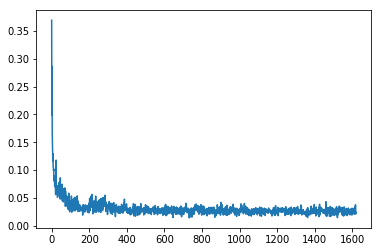

In [8]:
loss = np.array(train_pipeline.get_variable('loss'))
plt.plot(loss)
plt.show()

In [24]:
train_pipeline.save_model_now('unet', './unet_att_model')

## Inference

For inference we need a ```TraceIndex```, we also keep all SEGY headers from original traces:

In [24]:
inference_index = TraceIndex(name='raw', extra_headers='all', path=path_raw)

Inference pipeline. Note that one should specify temporary folder where processed batches will be stored before final merge.

In [25]:
tmp_dump_path = '/notebooks/egor/geolog/notebooks/tmp'

model_config = {
    "build": False,
    "load": {"path": './unet_att_model'},
}

def make_data_inference(batch, **kwagrs):
    return {"feed_dict": {'trace_raw': tfstack(batch.raw),
                          'offset': np.vstack(batch.trace_headers('offset'))}}

inference_ppl = (Pipeline()
                 .import_model('unet', train_pipeline)
#                  .init_model("static", UnetAtt, 'unet', config=model_config)
                 .init_variable('res')
                 .init_variable('count', init_on_each_run=0)
                 .load(components='raw', fmt='segy', tslice=np.arange(3000))
                 .predict_model('unet', make_data=make_data_inference,
                                fetches=['out_lift'], save_to=B('raw'))
                 .dump(path=F(lambda _, x: os.path.join(tmp_dump_path, str(x) + '.sgy'), V('count')),
                       src='raw', fmt='segy', split=False)
                 .update_variable('count', F(lambda _, x: x + 1, V('count'))))

Specify a dataset for inference pipeline:

In [26]:
inference_set = Dataset(inference_index,  SeismicBatch)

inference_ppl = inference_ppl << inference_set

Run inference pipeline with appropriate ```batch_size```:

In [27]:
batch_size = 2500
inference_ppl.run(batch_size, n_epochs=1, drop_last=False, shuffle=False, bar=True)

 99%|█████████▊| 70/71 [02:49<00:02,  2.43s/it]


Final and rather optional step is to merge dumped files into a single file:

In [28]:
output_path = '/notebooks/egor/geolog/notebooks/processed/merged.sgy'
merge_segy_files(output_path=output_path, extra_headers='all',
                 path=os.path.join(tmp_dump_path, '*.sgy'))

100%|██████████| 71/71 [01:09<00:00,  1.05s/it]


For a quick estimation let's look at the first field record from the final file:

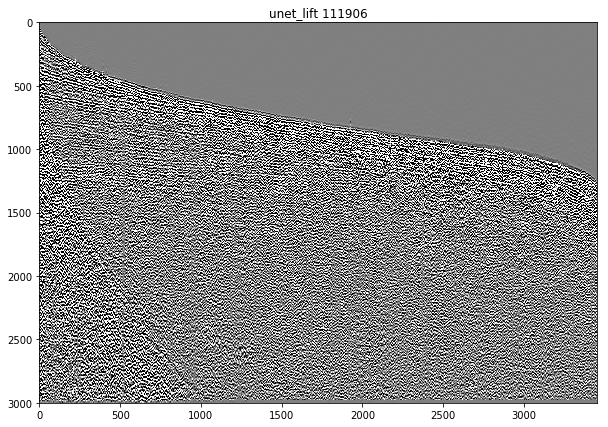

In [29]:
output_index = FieldIndex(name='unet_lift', extra_headers=['offset'], path=output_path)

(Dataset(output_index, SeismicBatch).next_batch(1)
 .load(components='unet_lift', fmt='segy', tslice=np.arange(3000))
 .sort_traces(src='unet_lift', dst='unet_lift', sort_by='offset')
 .seismic_plot('unet_lift', index.indices[0], figsize=(10, 7), vmax=0.1, vmin=-0.1, cmap='gray'))

## Running time

For GTX 1080 we obtain:
* training time per one batch of size 64 traces is 0.2 sec
* full model training time with batch size 64 is 6:28 min
* inference time per one batch of size 2500 traces is 2.4 sec

## Model evaluation

For model evaluation we 1) consider attention mask produced by model and compare it with thresholded absolute difference of target and input traces; 2) inspect attention mask parameters (sigmoid center and smoothness); 3) compare signal power spectrum in ground-roll area between target seismogram and model output.

Test pipeline:

In [7]:
model_config = {
    "build": False,
    "load": {"path": './unet_att_model'},
}

fetches=['out_lift', 'attention_sigmoid', 'sigmoid_center']

test_pipeline = (Pipeline()
#                  .import_model('unet', train_pipeline)
                 .init_model("static", UnetAtt, 'unet', config=model_config)
                 .init_variable('res', init_on_each_run=list())
                 .init_variable('raw', init_on_each_run=list())
                 .init_variable('lift', init_on_each_run=list())
                 .init_variable('offset', init_on_each_run=list())
                 .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                 .update_variable('raw', B('raw'), mode='a')
                 .update_variable('lift', B('lift'), mode='a')
                 .call(lambda batch, *args: batch.index.get_df()['offset'].values,
                       save_to=V('offset', mode='a'))
                 .predict_model('unet', make_data=make_data, fetches=fetches, save_to=V('res', 'a')))

INFO:tensorflow:Restoring parameters from ./unet_att_model/model-1620


Select a sample seismogram for testing:

In [8]:
i = 20
test_set = Dataset(TraceIndex(index.create_subset(index.indices[i: i+1])),
                   SeismicBatch)

Run test pipeline:

In [9]:
test_pipeline = test_pipeline << test_set
test_pipeline = test_pipeline.run(batch_size=1000, n_epochs=1, drop_last=False,
                                  shuffle=False, bar=True)

 75%|███████▌  | 3/4 [00:03<00:01,  1.18s/it]


Arrange results:

In [10]:
raw = np.vstack([np.vstack(x) for x in test_pipeline.get_variable('raw')])
lift = np.vstack([np.vstack(x) for x in test_pipeline.get_variable('lift')])
offset = np.hstack([x for x in test_pipeline.get_variable('offset')])
out = np.squeeze(np.vstack([x[0] for x in test_pipeline.get_variable('res')]))
att = np.squeeze(np.vstack([x[1] for x in test_pipeline.get_variable('res')]))
sigm_center = np.vstack([x[2] for x in test_pipeline.get_variable('res')])

### Visual estimation

Show raw seismogram, model attention mask, model output and difference between model output and raw input:

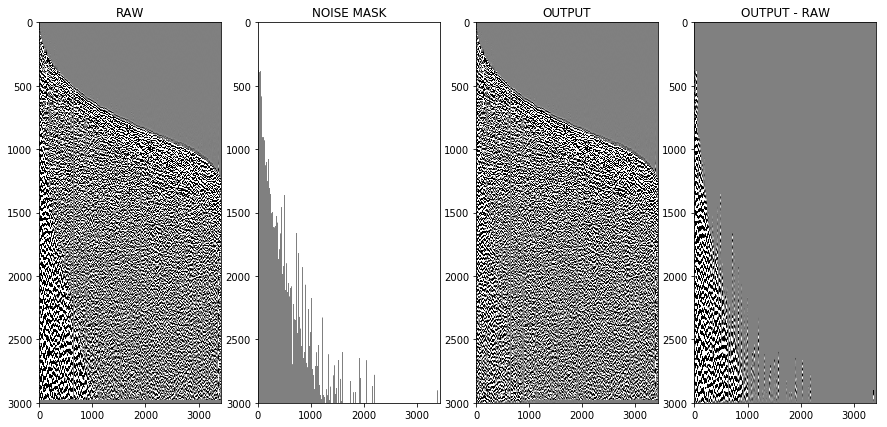

In [14]:
cv = 0.1
seismic_plot([raw, att, out, out - raw],
             figsize=(15, 7), names=['RAW', 'NOISE MASK', 'OUTPUT', 'OUTPUT - RAW'],
             cmap='gray', vmin=-cv, vmax=cv)

Show model output, traget seismogram difference between them:

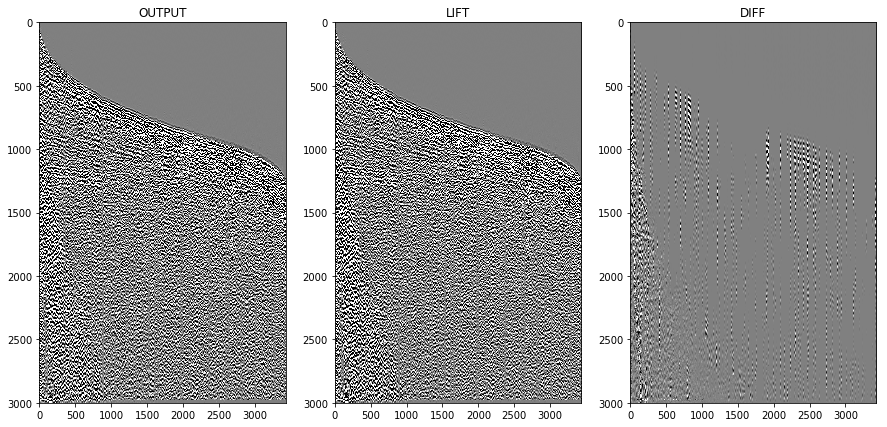

In [13]:
seismic_plot([out, lift, out - lift],
             figsize=(15, 7), names=['OUTPUT', 'LIFT', 'DIFF'],
             cmap='gray', vmin=-cv, vmax=cv)

Note a difference outside the ground-roll area.

### MAE metrics

Estimate MAE between model output and target seismogram:

In [14]:
mtr = FieldMetrics(lift, out)
print('MAE:', mtr.mae())

MAE: 0.0068779206


### Trace correlations

Get correlation coeffitiens between target traces and model output:

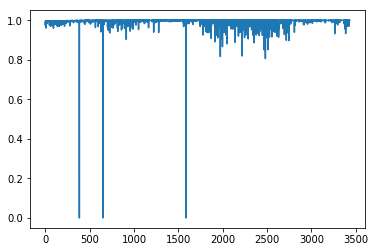

In [15]:
corr = mtr.corrcoef(reduce=None)
plt.plot(corr)
plt.show()

Note that zero correlation occurs due to zero traces in the dataset.

Average correlation is:

In [16]:
print('Averaged correlation:', mtr.corrcoef())

Averaged correlation: 0.9939664


### IOU for attention mask

Plot sigmoid center locations. We observe a non-trivial dependence of sigmoid parameters on traces and offsets: 

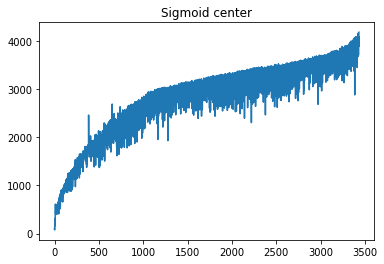

In [17]:
plt.plot(sigm_center[:, 0])
plt.title('Sigmoid center')
plt.show()

Comparison of attention mask and thresholded absolute difference between raw inputs and target traces:

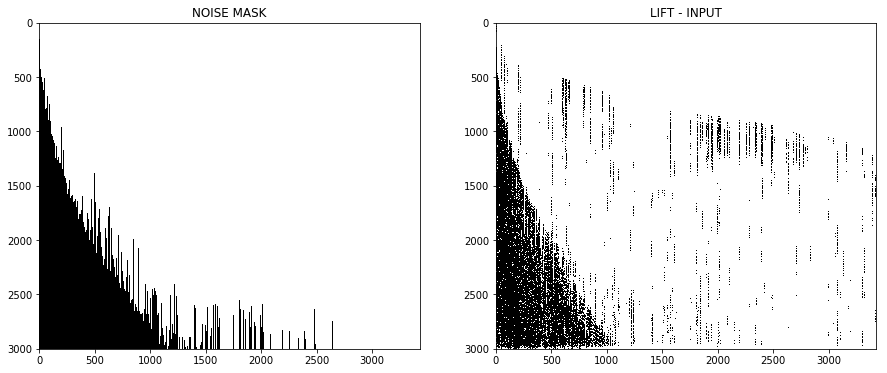

In [18]:
seismic_plot([att > 0.5, abs(lift - raw) < .05],
             names=['NOISE MASK', 'LIFT - INPUT'],
             figsize=(15, 6), vmin=0, vmax=1, cmap='gray')

Compute IOU for various threshold values:

In [19]:
thrs = np.arange(0, .5, 0.01)
vals = np.array([FieldMetrics(abs(lift - raw) > p, att < 0.5).iou() for p in thrs])

Plot of IOU metrics aganist various threshold values. We find that threshold at 0.05 gives maximum of IOU:

Best threshold is 0.04 with IOU =  0.7638880138907029


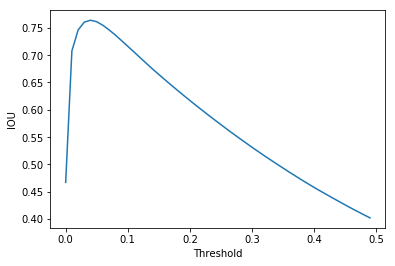

In [20]:
plt.plot(thrs, vals)
plt.xlabel('Threshold'), plt.ylabel('IOU')
print('Best threshold is', thrs[np.argmax(vals)], 'with IOU = ', vals.max())
plt.show()

### Power spectrum comparison

Power spectrum comparison in the gourd roll area:

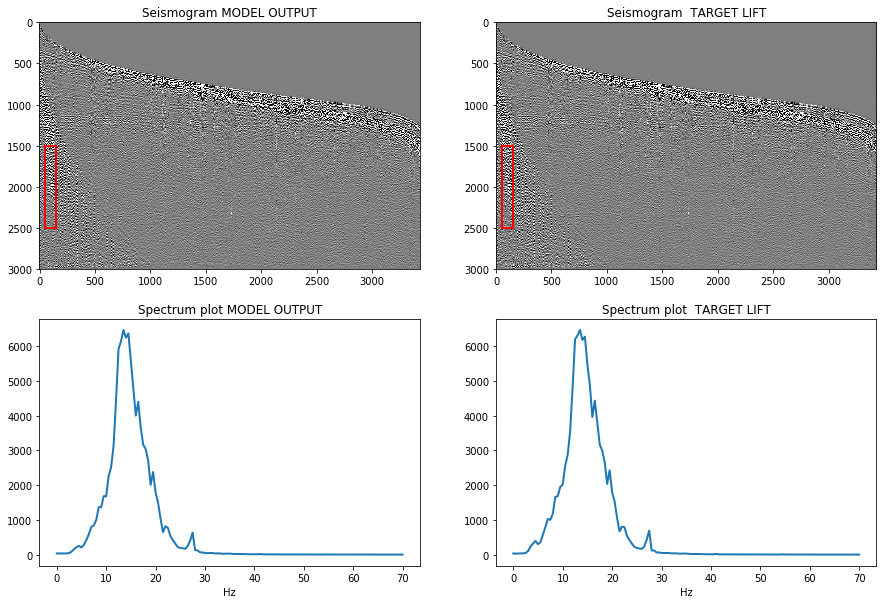

In [21]:
spectrum_plot([out, lift], frame=(slice(50, 150), slice(1500, 2500)), rate=0.002, max_freq=70,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray', names=['MODEL OUTPUT', ' TARGET LIFT'])

We observe a very similar distribution of power spectrum in the gound-roll area. We do not show plots outside the gound-roll area since the signal is unchanged there due to attention mask.

### Trace statistics comparison

Comparison of rms amplitudes:

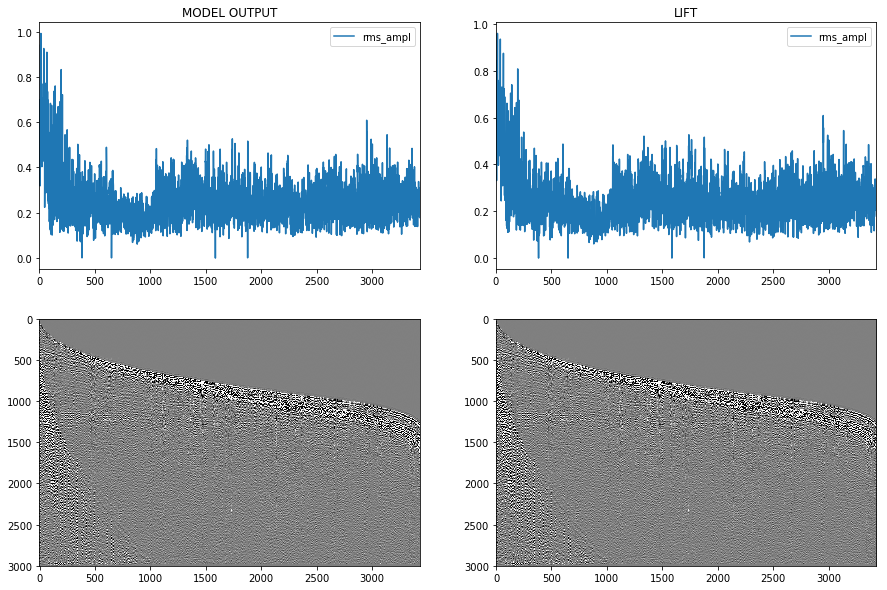

In [22]:
statistics_plot((out, lift), stats='rms_ampl', names=['MODEL OUTPUT', 'LIFT'], figsize=(15, 10),
                vmin=-cv, vmax=cv, cmap='gray')

Comparison of rms frequencies:

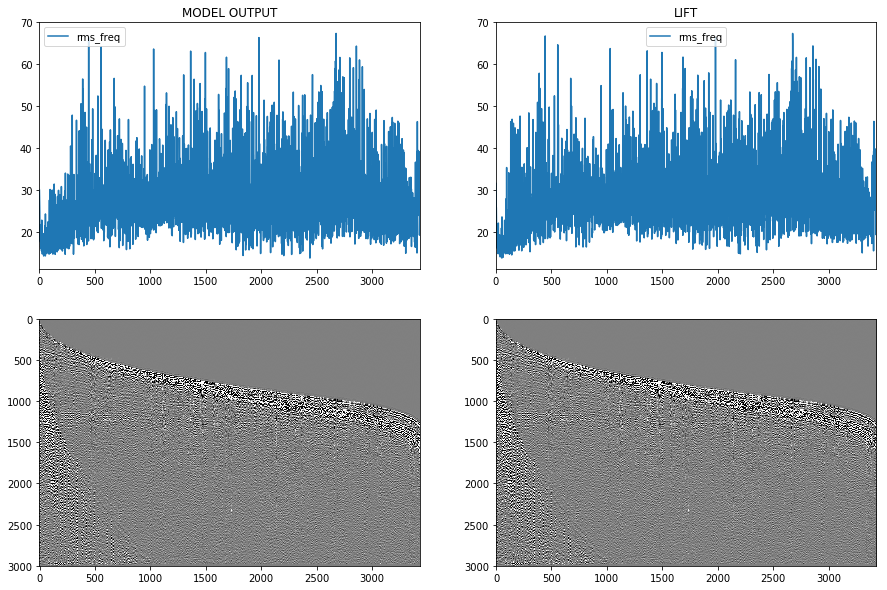

In [23]:
statistics_plot((out, lift), stats='rms_freq', rate=0.002,
                names=['MODEL OUTPUT', 'LIFT'], figsize=(15, 10),
                vmin=-cv, vmax=cv, cmap='gray')

We obsereve that while rms amplitudes are pretty the same, rms frequencies are somewhat differ for small offsets.

## Criticism

The model is not stable to intializations. Alternative initializations may produce sigmoid parameters depending on trace offset only or zero-constant values. However, it is more or less stable that 1 of 5 initializations results in reasonable sigmoid parameters.

## Conclusion

The Unet Attention model is possible tp provide reasonable noise attentiation in the ground-roll area and leaves signal untouched outside the ground-roll area due to in-situ estimated attention mask. However, traning of the model is sensitive to model initializations and requires accurate balansing of the loss terms. 

## Suggestions for improvements

Adding more constraints on sigmoid parameters to the loss function or clipping values inside the model should help to overcome the model instability. 